# Import

In [612]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.rnsga3 import RNSGA3
import statsmodels.api as sm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button

from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.interpolate import CubicSpline, Akima1DInterpolator
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
from sklearn import linear_model
from tqdm.notebook import trange, tqdm
from pynverse import inversefunc
import scipy as sp
from joblib import Parallel, delayed 
import pandas as pd
from routines_model import *
from routines_GA import *
from multiprocessing import Pool
import multiprocessing
import pickle
import emcee
import corner
import pygtc 
import os
%load_ext line_profiler
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model

In [69]:
b_k = np.array([0.018986, 0.016354, 0.013055, 0.008849, 0.004248])/0.023 #
muy_k = np.array([4.257564, 7.456665, 17.910194, 17.366595, 5.579378])
phi_k = np.array([30.739, -157.801, 140.577, -55.885, 77.107])
phi_k = phi_k/180/3600*np.pi

muy_k = muy_k/180/3600*np.pi*1e6
p0 = 50.467718
p0 = p0/180/3600*np.pi*1e6

# b_k

ordering = [4, 1, 3, 2, 0]
b_k = b_k[ordering]
muy_k = muy_k[ordering]
phi_k = phi_k[ordering]


fe_k = np.array([3.199279, 13.651920, 10.456224, 13.109803, 9.909679])
fe_k = fe_k/180/3600*np.pi
fe_k = fe_k*1e6


In [657]:
np.random.seed(126)
"Generate an age model"
N_data = 1001
depth = np.linspace(0,1,N_data)
func_inv_SR = partial(sine_inverse_SR, A=0.3, k=10)
# func_inv_SR = partial(linear_inverse_SR, a=-1.2)
# func_inv_SR = partial(logistic_inverse_SR, A=0.4, k=50)
# func_inv_SR = partial(heart_wave_inverse_SR, A=0.2, k=2)
# func_inv_SR = constant_inverse_SR
invSR = func_inv_SR(depth)
time = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)
time_true = time
"""Generate an data"""

"EP model"
fs = muy_k + p0
phi_true = np.random.rand(len(fs))*np.pi
ABtrue = np.hstack([np.cos(phi_true), np.sin(phi_true)])
ABtrue = ABtrue*np.hstack([b_k,b_k])
freqs_true = np.hstack([p0, muy_k])
X_true = generate_X_linReg(np.ones_like(muy_k), fs, time)
y_EP = X_true @ ABtrue
y_model = y_EP

"Noise"

sigma_true = 0.7
rho_true = 0.7

white_noise = np.random.randn(N_data)*sigma_true
arparams = np.array([rho_true])
ar = np.r_[1, -arparams] # add zero-lag and negate
arma_process = sm.tsa.ArmaProcess(ar)
red_noise = arma_process.generate_sample(N_data)
red_noise = red_noise*np.sqrt(1-rho_true**2)*sigma_true
noise = red_noise
# noise = white_noise

"data"
y = y_model + noise
    
# "simple model"
# f1 = 100; f2= 4.3*100
# A1 = 1; A2 = 1.2
# y_model = A1*np.cos(f1*time) + A2*np.cos(f2*time)
# fs =  np.array([f1, f2])
# y = y_model + noise


In [71]:
np.std(red_noise)
np.std(y_model)

0.982827584969121

In [283]:
invCov = np.identity(8)
np.fill_diagonal(invCov[1:-1,1:-1], 1+rho_AR1**2) 
np.fill_diagonal(invCov[1:,:-1], -rho_AR1) 
np.fill_diagonal(invCov[:-1,1:], -rho_AR1) 
# invCov = invCov/(sigma**2)/(1-rho_AR1**2)
invCov

array([[ 1.  , -0.5 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-0.5 ,  1.25, -0.5 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.5 ,  1.25, -0.5 ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.5 ,  1.25, -0.5 ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.5 ,  1.25, -0.5 ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.5 ,  1.25, -0.5 ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.5 ,  1.25, -0.5 ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.5 ,  1.  ]])

Text(0.5, 0, 'depth')

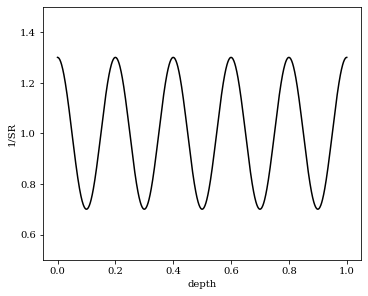

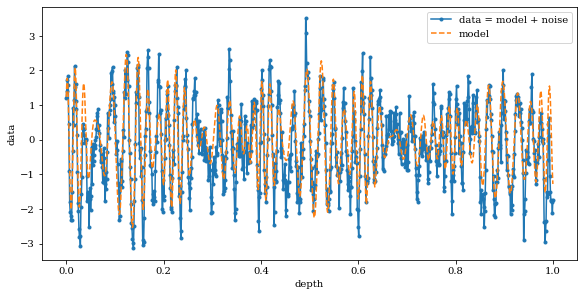

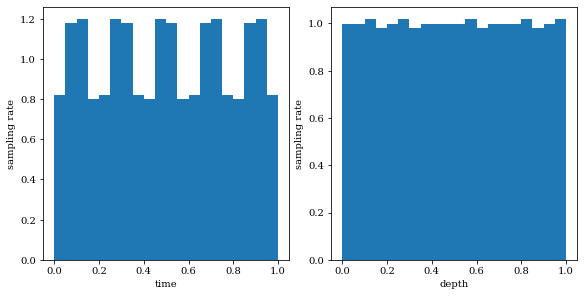

In [658]:
%matplotlib inline
"plot"
# plt.subplots(1,2)
plt.figure(figsize=(5,4), constrained_layout=True)
plt.subplot(1,1,1)
plt.plot(depth, invSR, color="black")
# plt.ylim([0,2])
plt.ylim([0.5,1.5])

plt.xlabel("depth")
plt.ylabel("1/SR")
# plt.subplot(1,2,2)
# plt.xlabel("depth")
# plt.ylabel("time")
# plt.plot(depth, time, color="black")
# plt.savefig("figures/invSR_sinek3.png",dpi=200)


plt.figure(figsize=(8,4), constrained_layout=True)
plt.plot(depth, y, '.-', label="data = model + noise")
plt.plot(depth, y_model,'--', label="model")
plt.xlabel("depth")
plt.ylabel("data")
plt.legend()
# plt.savefig("figures/data_sinek3.png",dpi=200)
# plt.figure(figsize=(15,4))
# plt.plot(time, y)
# plt.plot(time, y_model,'--')
# plt.scatter(time, np.ones_like(time)*-4, s=0.1, color="black")
# plt.xlabel("time")
# plt.ylabel("data")

plt.figure(figsize=(8,4), constrained_layout=True)
n = 2
plt.subplot(1,n,1)
plt.hist(time, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("time")
plt.subplot(1,n,2)
plt.hist(depth, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("depth")

# GA

In [219]:
class invSRinference(ElementwiseProblem):

    def __init__(self, depth_genes, genes_lims, interpolator, data, fs, n_pieces=1, metric=metric):

        self.invSR_lims = genes_lims
        self.depth_genes = depth_genes 
        self.interpolator = interpolator
        self.data = data
        self.fs = fs

        N_genes = len(depth_genes)
        xl = np.zeros(N_genes) + genes_lims[0]
        xu = np.zeros(N_genes) + genes_lims[1]
        self.func_metric = partial(metric, data=data, fs=fs, interpolator=interpolator, n_pieces=n_pieces)
        super().__init__(n_var=N_genes, n_obj=n_pieces, xl=xl, xu=xu)

    def _evaluate(self, genes, out, *args, **kwargs):
        
        out["F"] = -self.func_metric([self.depth_genes, genes])

class invSRinference_reg(ElementwiseProblem):

    def __init__(self, depth_genes, genes_lims, interpolator, data, fs, n_pieces=1, metric=metric):

        self.invSR_lims = genes_lims
        self.depth_genes = depth_genes 
        self.interpolator = interpolator
        self.data = data
        self.fs = fs

        N_genes = len(depth_genes)
        xl = np.zeros(N_genes) + genes_lims[0]
        xu = np.zeros(N_genes) + genes_lims[1]
        self.func_metric = partial(metric, data=data, fs=fs, interpolator=interpolator, n_pieces=n_pieces)
        super().__init__(n_var=N_genes, n_obj=n_pieces, xl=xl, xu=xu)

    def _evaluate(self, genes, out, *args, **kwargs):
        
        out["F"] = -self.func_metric([self.depth_genes, genes]) + 1e-5*np.sum(np.diff(genes)**2)


In [164]:
# N_population = 128 # number of individual in population 
# N_generations_max = 100
# N_genes = 12 # number of intial gene in an individial of the population 
depth_genes = np.linspace(0,1,N_genes)
true_genes = func_inv_SR(depth_genes)
invSR_lims = [0, 2]
fs = muy_k + p0
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
n_pieces = 2
metric_optimal = metric_piecewise([depth_genes, func_inv_SR(depth_genes)], [depth, y], fs, interpolator, n_pieces)
print(metric_optimal)
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
problem._evaluate(func_inv_SR(depth_genes), out)
out

[0.74413566 0.63362671]


{'F': array([-0.74413566, -0.63362671])}

## Vanilla NSGA 2

In [167]:
algorithm = NSGA2(
    pop_size=300,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 200)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# X = res.X
# F = res.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      300 |      5 |             - |             -
     2 |      400 |      3 |  0.1841964899 |         ideal
     3 |      500 |      4 |  0.0373374739 |         ideal
     4 |      600 |      5 |  0.0120128388 |         ideal
     5 |      700 |      6 |  0.1402020261 |         ideal
     6 |      800 |      7 |  0.0311921417 |         ideal
     7 |      900 |      6 |  0.1910552547 |         ideal
     8 |     1000 |      6 |  0.0464615841 |             f
     9 |     1100 |      5 |  0.2613871828 |         ideal
    10 |     1200 |      6 |  0.2517618351 |         ideal
    11 |     1300 |      7 |  0.0094448261 |             f
    12 |     1400 |      8 |  0.0118038481 |             f
    13 |     1500 |      8 |  0.0202159712 |             f
    14 |     1600 |     10 |  0.1783631420 |         ideal
    15 |     1700 |     11 |  0.0362904116 |         ideal
    16 |     1800 |      8 |  0.0597344773 |         ide

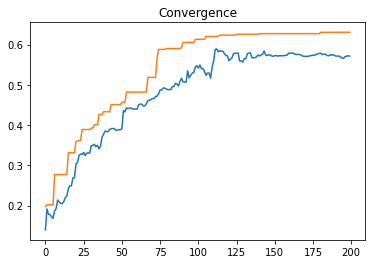

In [168]:
# opt = -np.array([e.opt[0].F for e in res.history])
opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
opt_max = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

plt.figure()
plt.title("Convergence")
# plt.plot(opt.mean(axis=1), "--")
plt.plot(opt_mean)
plt.plot(opt_max)

# plt.yscale("log")
plt.show()

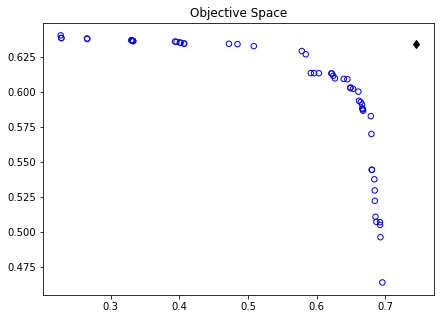

In [169]:
plt.figure(figsize=(7, 5))
plt.scatter(-res.F[:, 0], -res.F[:, 1], s=30, facecolors='none', edgecolors='blue')
f1min, f1max = -res.F[:,0].min(), -res.F[:,0].max()
f1grid = np.linspace(0, 1, 100)

# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


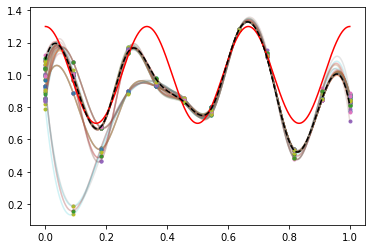

In [170]:
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]

for i in range(res.F.shape[0]):
    plt.plot(depth_genes, res.X[i], '.')
    invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    plt.plot(depth, invSR_interpolate, alpha=0.2)
plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black")
# invSR_interpolate[invSR_interpolate<0] = 0

# time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
# X = generate_X_linReg(np.ones_like(fs), fs, time)

# reg_model = LinearRegression().fit(X, y_data)
# y_pred = reg_model.predict(X)

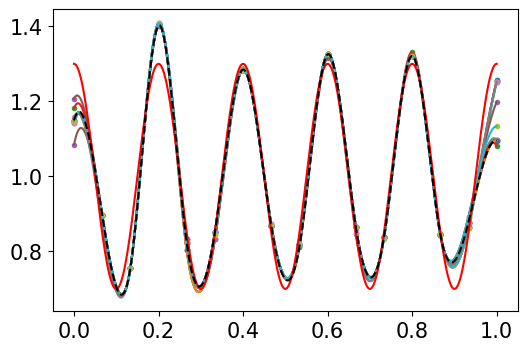

In [157]:
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]

for i in range(res.F.shape[0]):
    plt.plot(depth_genes, res.X[i], '.')
    invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    plt.plot(depth, invSR_interpolate)
plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black")
# invSR_interpolate[invSR_interpolate<0] = 0

# time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
# X = generate_X_linReg(np.ones_like(fs), fs, time)

# reg_model = LinearRegression().fit(X, y_data)
# y_pred = reg_model.predict(X)

## RNSGA 2

In [259]:
# N_population = 128 # number of individual in population 
# N_generations_max = 100
N_genes = 30 # number of intial gene in an individial of the population 
depth_genes = np.linspace(0,1,N_genes)
true_genes = func_inv_SR(depth_genes)
invSR_lims = [0, 2]
fs = muy_k + p0
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
n_pieces = 2
metric_optimal = metric_piecewise([depth_genes, func_inv_SR(depth_genes)], [depth, y], fs, interpolator, n_pieces)
print(metric_optimal)
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
problem._evaluate(func_inv_SR(depth_genes), out)
out

[0.73091511 0.631311  ]


{'F': array([-0.73091511, -0.631311  ])}

In [297]:
ref_points = np.array([[-1., -1.]])

# Get Algorithm
algorithm = RNSGA2(
    ref_points=ref_points,
    pop_size=200,
    epsilon=0.005,
    normalization='front',
    extreme_points_as_reference_points=True,
    # weights=np.array([0.5, 0.5])
    )
n_gen = 200
res = minimize(problem,
               algorithm,
               save_history=True,
               termination=('n_gen', n_gen),
               seed=1,
               disp=False,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |      5 |             - |             -
     2 |      400 |     10 |  0.2202055633 |         ideal
     3 |      600 |      7 |  0.0770326453 |             f
     4 |      800 |     10 |  0.2653455478 |         ideal
     5 |     1000 |     11 |  0.1277236819 |         ideal
     6 |     1200 |     10 |  0.1074660175 |         ideal
     7 |     1400 |     12 |  0.0155657609 |             f
     8 |     1600 |      9 |  0.0811512870 |         ideal
     9 |     1800 |      3 |  0.0570078713 |         ideal
    10 |     2000 |      6 |  0.0213161247 |         nadir
    11 |     2200 |      8 |  0.1008313197 |         ideal
    12 |     2400 |      9 |  0.0991510968 |         ideal
    13 |     2600 |      8 |  0.1186725321 |         ideal
    14 |     2800 |      8 |  0.0199832828 |         ideal
    15 |     3000 |     11 |  0.0227251308 |             f
    16 |     3200 |      7 |  0.0661399486 |         ide

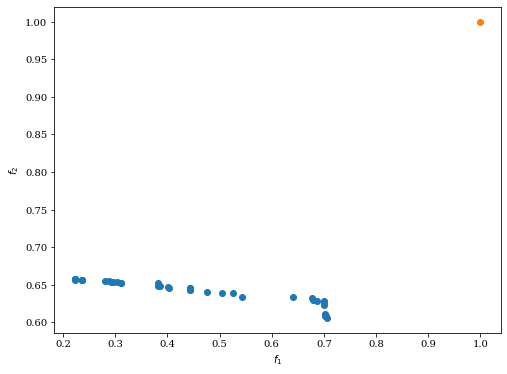

In [300]:
Scatter().add(-res.F, label="F").add(-ref_points, label="ref_points").show()

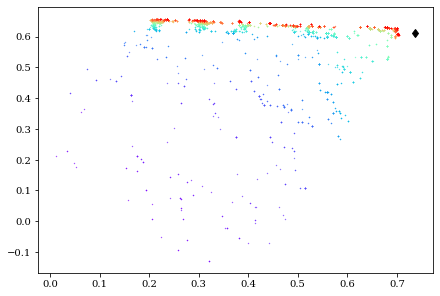

In [301]:
fig = plt.figure(figsize=(6,4), constrained_layout=True)

Fhistory = [np.array([-indi.F for indi in res.history[i].opt]) for i in range(n_gen) ] 
cmap = plt.get_cmap("rainbow")
for i in range(n_gen):
    plt.scatter(Fhistory[i][:,0], Fhistory[i][:,1],  color=cmap(i/n_gen), s=0.1)
plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")


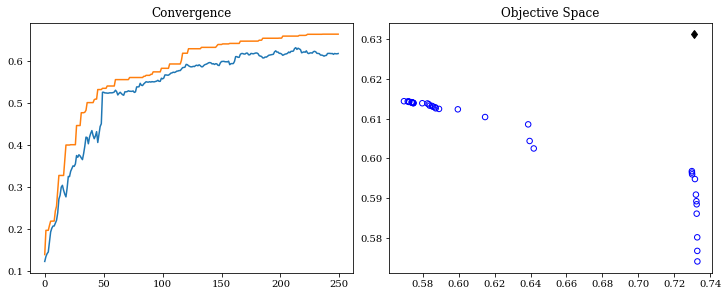

In [266]:
# opt = -np.array([e.opt[0].F for e in res.history])
opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
opt_max = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

plt.figure(figsize=(10,4), constrained_layout=True)
plt.subplot(1,2,1)
plt.title("Convergence")
# plt.plot(opt.mean(axis=1), "--")
plt.plot(opt_mean)
plt.plot(opt_max)

# plt.figure(figsize=(7, 5))
plt.subplot(1,2,2)
plt.scatter(-res.F[:, 0], -res.F[:, 1], s=30, facecolors='none', edgecolors='blue')
f1min, f1max = -res.F[:,0].min(), -res.F[:,0].max()
f1grid = np.linspace(0, 1, 100)

# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()

# plt.yscale("log")
plt.show()

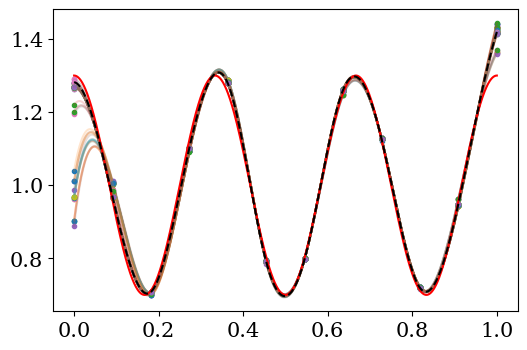

In [181]:
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]

for i in range(res.F.shape[0]):
    plt.plot(depth_genes, res.X[i], '.')
    invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    plt.plot(depth, invSR_interpolate, alpha=0.2)
plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black")
# invSR_interpolate[invSR_interpolate<0] = 0

# time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
# X = generate_X_linReg(np.ones_like(fs), fs, time)

# reg_model = LinearRegression().fit(X, y_data)
# y_pred = reg_model.predict(X)

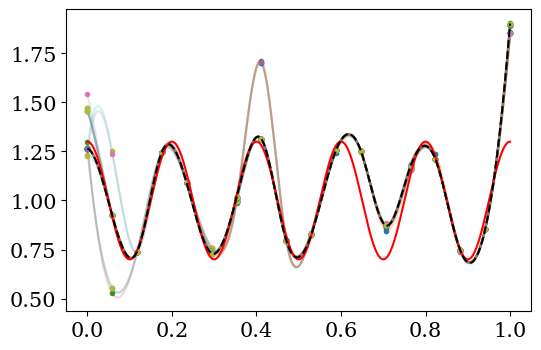

In [234]:
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]

for i in range(res.F.shape[0]):
    plt.plot(depth_genes, res.X[i], '.')
    invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    plt.plot(depth, invSR_interpolate, alpha=0.2)
plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black")
# invSR_interpolate[invSR_interpolate<0] = 0

# time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
# X = generate_X_linReg(np.ones_like(fs), fs, time)

# reg_model = LinearRegression().fit(X, y_data)
# y_pred = reg_model.predict(X)

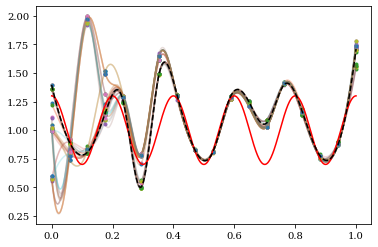

In [302]:
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]

for i in range(res.F.shape[0]):
    plt.plot(depth_genes, res.X[i], '.')
    invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    plt.plot(depth, invSR_interpolate, alpha=0.2)
plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black")
# invSR_interpolate[invSR_interpolate<0] = 0

# time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
# X = generate_X_linReg(np.ones_like(fs), fs, time)

# reg_model = LinearRegression().fit(X, y_data)
# y_pred = reg_model.predict(X)

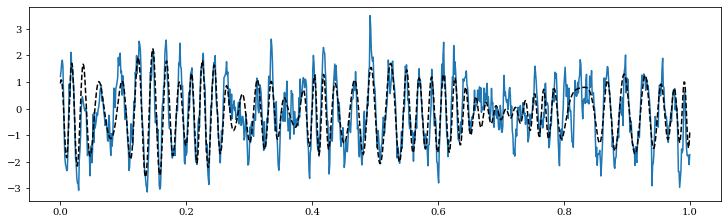

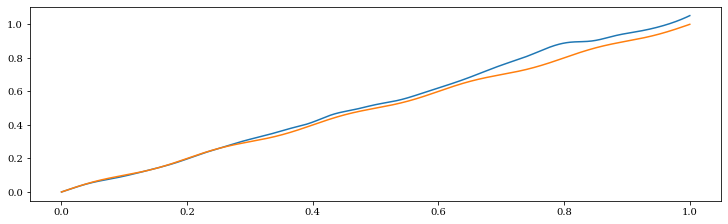

In [268]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, y)

invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)

time_pred, y_pred = invSR_to_predx([depth_genes, invSR_best])

ax.plot(depth, y_pred, "--", color="black")


fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

ax.plot(depth, time_pred)
ax.plot(depth, time_true)


## RNSGA 3

In [484]:
# N_population = 128 # number of individual in population 
# N_generations_max = 100
N_genes = 18 # number of intial gene in an individial of the population 
depth_genes = np.linspace(0,1,N_genes)
true_genes = func_inv_SR(depth_genes)
invSR_lims = [0, 2]
fs = muy_k + p0
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
n_pieces = 4
metric_optimal = metric_piecewise([depth_genes, func_inv_SR(depth_genes)], [depth, y], fs, interpolator, n_pieces)
print(metric_optimal)
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
problem._evaluate(func_inv_SR(depth_genes), out)
out

[0.79851221 0.64282072 0.65931247 0.57745558]


{'F': array([-0.79851221, -0.64282072, -0.65931247, -0.57745558])}

In [332]:
np.array([[1., 1.]]).shape,  np.ones((1,n_pieces)).shape

((1, 2), (1, 2))

In [470]:
get_reference_directions?

Signature: get_reference_directions(name, *args, **kwargs)
Docstring: <no docstring>
File:      ~/conda/myenv/lib/python3.9/site-packages/pymoo/util/ref_dirs/__init__.py
Type:      function


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      210 |      7 |             - |             -
     2 |      420 |      6 |  0.3641673045 |         ideal
     3 |      630 |      6 |  0.1715347461 |         ideal
     4 |      840 |      6 |  0.000000E+00 |             f
     5 |     1050 |      6 |  0.0671908432 |             f
     6 |     1260 |      6 |  0.3326963733 |         ideal
     7 |     1470 |      6 |  0.4683368752 |         ideal
     8 |     1680 |      6 |  0.3001134205 |         ideal
     9 |     1890 |      6 |  0.2718886348 |         ideal
    10 |     2100 |      6 |  0.1331600418 |         ideal
    11 |     2310 |      7 |  0.1156824010 |         ideal
    12 |     2520 |      7 |  0.0566399499 |         ideal
    13 |     2730 |      7 |  0.0223279523 |         ideal
    14 |     2940 |      8 |  0.1653075584 |         nadir
    15 |     3150 |      7 |  0.1470265442 |         ideal
    16 |     3360 |      7 |  0.2584397367 |         ide

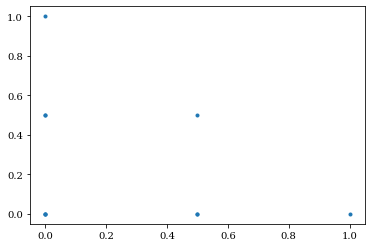

In [519]:
# Define reference points
# Get Algorithm
# ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=4)
ref_dirs = get_reference_directions("energy", n_pieces, 10, seed=1)
plt.plot(ref_dirs[:,0], ref_dirs[:,1], '.')
ref_dirs.shape
algorithm = NSGA3(
    ref_dirs=ref_dirs,
    pop_size=210,
    )

res = minimize(problem,
               algorithm=algorithm,
                save_history=True,
               termination=('n_gen', 400),
            #    seed=1,
               verbose=True)


In [ ]:
# Define reference points
ref_points = -np.ones((1,n_pieces))
# ref_points = np.array([[1., 1.]])
# Get Algorithm
algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=400,
    mu=0.1)

res = minimize(problem,
               algorithm=algorithm,
                save_history=True,
               termination=('n_gen', 200),
            #    seed=1,
               verbose=True)


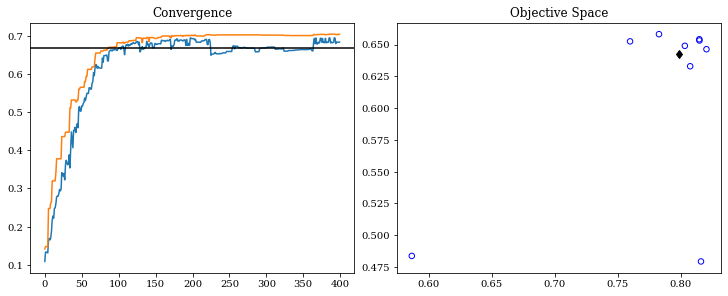

In [520]:
# opt = -np.array([e.opt[0].F for e in res.history])
opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
opt_max = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

plt.figure(figsize=(10,4), constrained_layout=True)
plt.subplot(1,2,1)
plt.title("Convergence")
# plt.plot(opt.mean(axis=1), "--")
plt.plot(opt_mean)
plt.plot(opt_max)
plt.axhline(metric_optimal.mean(), color="k")

# plt.figure(figsize=(7, 5))
plt.subplot(1,2,2)
plt.scatter(-res.F[:, 0], -res.F[:, 1], s=30, facecolors='none', edgecolors='blue')
f1min, f1max = -res.F[:,0].min(), -res.F[:,0].max()
f1grid = np.linspace(0, 1, 100)

# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()

# plt.yscale("log")
plt.show()

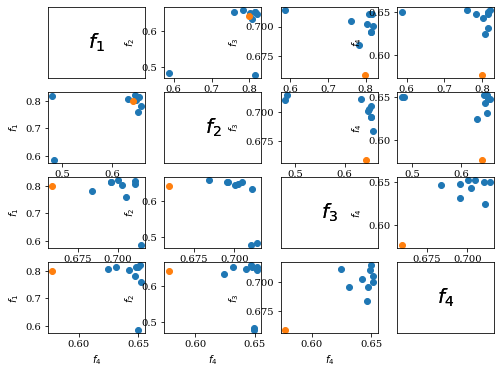

In [521]:
# reference_directions = res.algorithm.survival.ref_dirs
plot = Scatter()
plot.add(-res.F, label="F")
plot.add(metric_optimal, label="ref_points")
# plot.add(reference_directions, label="ref_dirs")
plot.show()

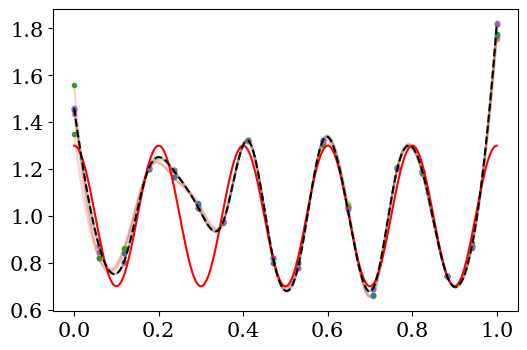

In [497]:
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]

for i in range(res.F.shape[0]):
    plt.plot(depth_genes, res.X[i], '.')
    invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    plt.plot(depth, invSR_interpolate, alpha=0.2)
plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black")
# invSR_interpolate[invSR_interpolate<0] = 0

# time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
# X = generate_X_linReg(np.ones_like(fs), fs, time)

# reg_model = LinearRegression().fit(X, y_data)
# y_pred = reg_model.predict(X)

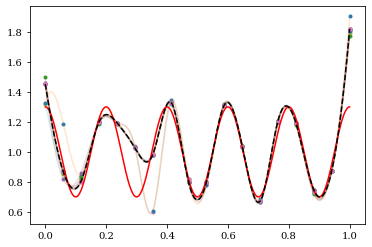

In [522]:
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]

for i in range(res.F.shape[0]):
    plt.plot(depth_genes, res.X[i], '.')
    invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    plt.plot(depth, invSR_interpolate, alpha=0.2)
plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black")
# invSR_interpolate[invSR_interpolate<0] = 0

# time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
# X = generate_X_linReg(np.ones_like(fs), fs, time)

# reg_model = LinearRegression().fit(X, y_data)
# y_pred = reg_model.predict(X)

## With regularization

In [447]:
# invSR_spline = CubicSpline(depth_genes, func_inv_SR(depth_genes))
# invSR_interpolate = invSR_spline(depth)
# second_der = invSR_spline.derivative(2)
# roughness = sp.integrate.quad(lambda x: second_der(x)**2, depth[0], depth[-1])[0]

In [407]:
# sp.integrate.simpson(second_der(depth)**2, depth)
# sp.integrate.cumulative_trapezoid(second_der(depth)**2, depth)

# cumulative_trapezoid
# sp.integrate.quad(lambda x: second_der(x)**2, depth[0], depth[-1])[0]

NameError: name 'cumulative_trapezoid' is not defined

In [397]:
# %timeit  sp.integrate.quad(lambda x: second_der(x)**2, depth[0], depth[-1][0])

# %timeit sp.integrate.simpson(second_der(depth)**2, depth)

54 µs ± 691 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [431]:
class invSRinference_reg(ElementwiseProblem):

    def __init__(self, depth_genes, genes_lims, spline, data, fs, n_pieces=1, metric=metric_piecewise_reg, lambda_reg=0):

        self.invSR_lims = genes_lims
        self.depth_genes = depth_genes 
        self.spline = spline
        self.data = data
        self.fs = fs

        N_genes = len(depth_genes)
        xl = np.zeros(N_genes) + genes_lims[0]
        xu = np.zeros(N_genes) + genes_lims[1]
        self.func_metric = partial(metric, data=data, fs=fs, spline=spline, n_pieces=n_pieces, invSR_lims=genes_lims, lambda_reg=lambda_reg)
        super().__init__(n_var=N_genes, n_obj=n_pieces, xl=xl, xu=xu)

    def _evaluate(self, genes, out, *args, **kwargs):
        
        out["F"] = -self.func_metric([self.depth_genes, genes])

def metric_piecewise_reg(depth_invSR, data, fs, spline=CubicSpline, n_pieces=1, invSR_lims=None, metric_type="r2", lambda_reg=0, *args, **kwargs):
    """_summary_: 
    
        metric  (according to the metric type) for the linear model with predictors variable are fourier harmonics of frequencies fs
        of fitting the data, when used the age model derived from the invSR.
        age model: given points of inverse SR, interpolate with an interpolator and integrate along depth
        to obtain time.
        with penalty terms for roughness with coefficient lambda : integral of squared of second derivative of the invSR function    
    Args:
        depth_invSR (array[2,n]): inverse of sedimetation rates and their corresponding depth 
        interpolator: interpolator
        data (array[2,m]): the data and corresponding depth
        fs (_type_): list of frequencies of the model
        metric_type (str, optional):"BIC", "AIC" or "RSS". Defaults to "BIC".
            Returns:
        int: metric
           
    """

    depth, y_data = data

    invSR_spline = spline(*depth_invSR)
    invSR_interpolate = invSR_spline(depth)
    second_der = invSR_spline.derivative(2)
    # if lambda_reg != 0:
    #     second_der = invSR_spline.derivative(2)
    #     # roughness = sp.integrate.quad(lambda x: second_der(x)**2, depth[0], depth[-1])[0]
    #     roughness = sp.integrate.simpson(second_der(depth)**2, depth)
    # else:
    #     roughness = 0
    if invSR_lims is not None:
        invSR_interpolate[invSR_interpolate<invSR_lims[0]] = invSR_lims[0]
        invSR_interpolate[invSR_interpolate>invSR_lims[1]] = invSR_lims[1]
    # print(lambda_reg*roughness)
    time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
    X = generate_X_linReg(np.ones_like(fs), fs, time)

    reg_model = LinearRegression().fit(X, y_data)
    y_pred = reg_model.predict(X)
    
    depth_pieces = np.linspace(depth[0], depth[-1], n_pieces+1)
    # r2 = np.zeros(n_pieces)
    # RSS = np.zeros(n_pieces)
    metrix = np.zeros(n_pieces)

    for i in range(n_pieces):
        j1, j2 = np.searchsorted(depth, depth_pieces[i],"left"),  np.searchsorted(depth, depth_pieces[i+1], "right")
        roughness = sp.integrate.simpson(second_der(depth[j1:j2])**2, depth[j1:j2])
        if metric_type == "r2":
            metrix[i] = r2_score(y_data[j1:j2], y_pred[j1:j2]) - lambda_reg*roughness
        elif metric_type == "RSS":
            metrix[i] = np.mean((y_data[j1:j2] - y_pred[j1:j2])**2)  - lambda_reg*roughness
        else:
            print("metric type not defined")
    return metrix

In [443]:
# N_population = 128 # number of individual in population 
# N_generations_max = 100
N_genes = 18 # number of intial gene in an individial of the population 
depth_genes = np.linspace(0,1,N_genes)
true_genes = func_inv_SR(depth_genes)
invSR_lims = [0, 2]
fs = muy_k + p0
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
n_pieces = 2
lambda_reg = 1e-7
# metric_optimal = metric_piecewise([depth_genes, func_inv_SR(depth_genes)], [depth, y], fs, interpolate_CubicSpline, n_pieces)
metric_optimal = metric_piecewise_reg([depth_genes, func_inv_SR(depth_genes)], [depth, y], fs, CubicSpline, n_pieces, lambda_reg=0)

print(metric_optimal)
print( metric_piecewise_reg([depth_genes, func_inv_SR(depth_genes)], [depth, y], fs, CubicSpline, n_pieces, lambda_reg=lambda_reg)-
      metric_piecewise([depth_genes, func_inv_SR(depth_genes)], [depth, y], fs, interpolate_CubicSpline, n_pieces))
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
# interpolator = interpolate_CubicSpline

data = [depth, y]
problem = invSRinference_reg(depth_genes, invSR_lims, CubicSpline, data, fs, n_pieces=n_pieces, metric=metric_piecewise_reg, lambda_reg=5e-7)
out = {}
problem._evaluate(func_inv_SR(depth_genes), out)
out

[0.73716823 0.61301467]
[-0.00194898 -0.00194898]


{'F': array([-0.72742332, -0.60326976])}

In [444]:
algorithm = NSGA2(
    pop_size=300,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 400)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# X = res.X
# F = res.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      300 |      7 |             - |             -
     2 |      400 |      6 |  0.0845294086 |             f
     3 |      500 |      4 |  0.0980973416 |         ideal
     4 |      600 |      4 |  0.2234156437 |         ideal
     5 |      700 |      1 |  0.0919378017 |         ideal
     6 |      800 |      1 |  0.000000E+00 |             f
     7 |      900 |      1 |  0.000000E+00 |             f
     8 |     1000 |      2 |  1.0000000000 |         ideal
     9 |     1100 |      3 |  0.1606612409 |         ideal
    10 |     1200 |      3 |  0.1262350483 |         ideal
    11 |     1300 |      3 |  0.000000E+00 |             f
    12 |     1400 |      3 |  0.000000E+00 |             f
    13 |     1500 |      4 |  0.0915342579 |             f
    14 |     1600 |      4 |  0.000000E+00 |             f
    15 |     1700 |      4 |  0.000000E+00 |             f
    16 |     1800 |      5 |  0.0435399040 |         ide

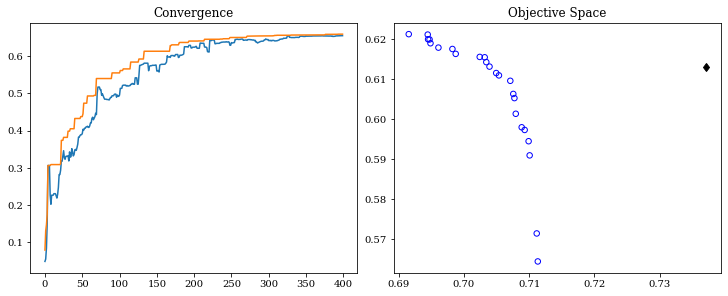

In [448]:
# opt = -np.array([e.opt[0].F for e in res.history])
opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
opt_max = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

plt.figure(figsize=(10,4), constrained_layout=True)
plt.subplot(1,2,1)
plt.title("Convergence")
# plt.plot(opt.mean(axis=1), "--")
plt.plot(opt_mean)
plt.plot(opt_max)

# plt.figure(figsize=(7, 5))
plt.subplot(1,2,2)
plt.scatter(-res.F[:, 0], -res.F[:, 1], s=30, facecolors='none', edgecolors='blue')
f1min, f1max = -res.F[:,0].min(), -res.F[:,0].max()
f1grid = np.linspace(0, 1, 100)

# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()

# plt.yscale("log")
plt.show()

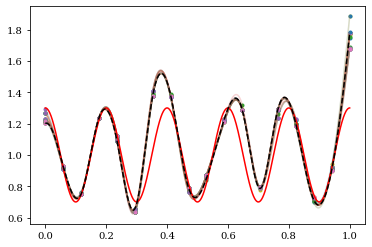

In [449]:
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]

for i in range(res.F.shape[0]):
    plt.plot(depth_genes, res.X[i], '.')
    invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    plt.plot(depth, invSR_interpolate, alpha=0.2)
plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black")
# invSR_interpolate[invSR_interpolate<0] = 0

# time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
# X = generate_X_linReg(np.ones_like(fs), fs, time)

# reg_model = LinearRegression().fit(X, y_data)
# y_pred = reg_model.predict(X)

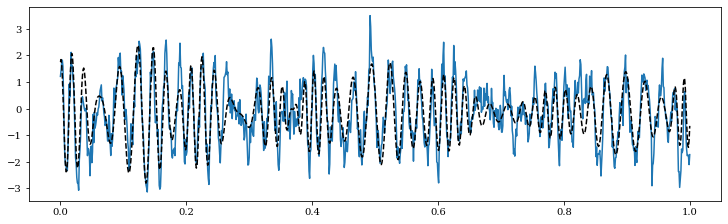

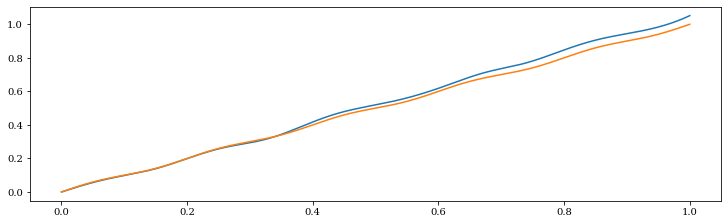

In [451]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, y)

invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)

time_pred, y_pred = invSR_to_predx([depth_genes, invSR_best])

ax.plot(depth, y_pred, "--", color="black")


fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

ax.plot(depth, time_pred)
ax.plot(depth, time_true)


## In search for optimal number of genes

In [578]:
# N_population = 128 # number of individual in population 
# N_generations_max = 100
N_genes = 30 # number of intial gene in an individial of the population 
depth_genes = np.linspace(0,1,N_genes)
true_genes = func_inv_SR(depth_genes)
invSR_lims = [0, 2]
fs = muy_k + p0
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
n_pieces = 2
metric_optimal = metric_piecewise([depth_genes, func_inv_SR(depth_genes)], [depth, y], fs, interpolator, n_pieces)
print(metric_optimal)
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
problem._evaluate(func_inv_SR(depth_genes), out)
out

[0.73091511 0.631311  ]


{'F': array([-0.73091511, -0.631311  ])}

In [523]:
class Callback_getF(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.data["best"] = []

    def notify(self, algorithm):
        b = algorithm.pop.get("F").mean(axis=1).min()
        self.data["best"].append(b)

In [580]:
algorithm = NSGA2(
    pop_size=400,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 500
termination = get_termination("n_gen", N_generations)
# N_genes_enemble = np.arange(2, 40, 1)

N_genes_same = 8
N_genes_distinct = np.arange(2, 30, 2)
N_genes_enemble = np.array([ np.array([i]*N_genes_same)  for i in  N_genes_distinct]).flatten()
depth_genes_ensemble = [np.linspace(0,1,N_genes) for N_genes in N_genes_enemble] 

N_ensemble = len(depth_genes_ensemble)

# N_genes_enemble = (np.tile(N_genes_enemble, 8).reshape(8, 14).T).flatten()
# N_genes_enemble

problems = [invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise) for depth_genes in depth_genes_ensemble  ] 

res_ensemble = Parallel(n_jobs=N_ensemble, verbose=100)(delayed(minimize)(problem, algorithm, termination, save_history=False, callback=Callback_getF())
                                                        for problem in problems)
# res_ensemble = Parallel(n_jobs=N_ensemble, verbose=100)(delayed(minimize)(problem, algorithm, termination, save_history=True) for problem in problems)


[Parallel(n_jobs=112)]: Using backend LokyBackend with 112 concurrent workers.
[Parallel(n_jobs=112)]: Done   1 tasks      | elapsed:  5.6min
[Parallel(n_jobs=112)]: Done   3 out of 112 | elapsed:  5.6min remaining: 204.8min
[Parallel(n_jobs=112)]: Done   5 out of 112 | elapsed:  5.8min remaining: 124.2min
[Parallel(n_jobs=112)]: Done   7 out of 112 | elapsed:  6.0min remaining: 89.4min
[Parallel(n_jobs=112)]: Done   9 out of 112 | elapsed:  6.0min remaining: 69.1min
[Parallel(n_jobs=112)]: Done  11 out of 112 | elapsed:  6.1min remaining: 56.0min
[Parallel(n_jobs=112)]: Done  13 out of 112 | elapsed:  6.1min remaining: 46.7min
[Parallel(n_jobs=112)]: Done  15 out of 112 | elapsed:  6.2min remaining: 40.1min
[Parallel(n_jobs=112)]: Done  17 out of 112 | elapsed:  6.3min remaining: 35.0min
[Parallel(n_jobs=112)]: Done  19 out of 112 | elapsed:  6.7min remaining: 33.0min
[Parallel(n_jobs=112)]: Done  21 out of 112 | elapsed:  6.9min remaining: 30.0min
[Parallel(n_jobs=112)]: Done  23 out

(0.1, 0.8)

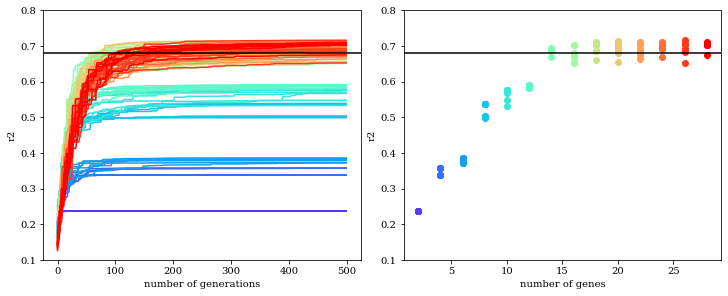

In [644]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])

    # opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))


metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], fs, interpolator, n_pieces)
plt.ylabel("r2")
plt.xlabel("number of generations")
plt.ylim([0.1, 0.8])
plt.axhline(metric_optimal.mean(), color="k")

# plt.yscale("log")
plt.subplot(1,2,2)
# ax2 = fig.add_subplot(gs1[0, 1])

# plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')
# [ for i in range(N_ensemble)]
for i in range(N_ensemble):
    plt.scatter(N_genes_enemble[i], opt_max_ensemble[i,-1], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    # metric_optimal = metric_piecewise([depth_genes_ensemble[i], func_inv_SR(depth_genes_ensemble[i])], [depth, y], fs, interpolator, n_pieces)
    # plt.axhline(metric_optimal.mean() , color=cmap(i/N_ensemble),zorder=-10)
plt.axhline(metric_optimal.mean(), color="k")

plt.xlabel("number of genes")
plt.ylabel("r2")
plt.ylim([0.1, 0.8])
# plt.savefig("r2_Ngenesb.png", dpi=200)

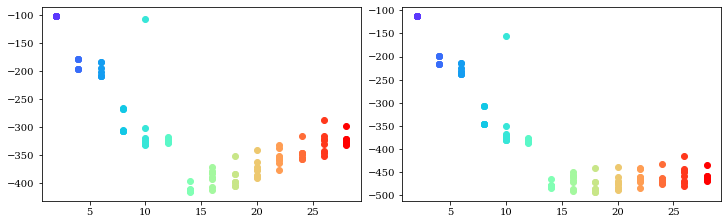

In [656]:
def maxlogL_to_BIC(maxlogL, n_params, n_data):
    return n_params*np.log(n_data) - 2*maxlogL
def maxlogL_to_AIC(maxlogL, n_params):
    return n_params*2 - 2*maxlogL

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble):
    res = res_ensemble[i]
    # if i<=40:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    # maxlogL  = log_likelihood_rednoise([depth_genes, func_inv_SR(depth_genes)], data, fs, [rho_true, sigma_true], interpolator=interpolate_CubicSpline)
    maxlogL  = log_likelihood_rednoise([depth_genes, res.X[arg_best]], data, fs, [rho_true, sigma_true], interpolator=interpolate_CubicSpline)

    # plt.scatter(N_genes_enemble[i], maxlogL, color=cmap(i/N_ensemble))
    axs[0].scatter(N_genes_enemble[i], maxlogL_to_BIC(maxlogL, N_genes_enemble[i], len(y)), color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    axs[1].scatter(N_genes_enemble[i], maxlogL_to_AIC(maxlogL, N_genes_enemble[i]), color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    # ax.plot(depth_genes, res.X[arg_best], '.', color=cmap(i/N_ensemble))
    
# x_genes = np.arange(2,30)
# maxlogL  = np.array([log_likelihood_rednoise([np.linspace(0,1,x_genes[i]), func_inv_SR(np.linspace(0,1,x_genes[i]))], data, fs, [rho_true, sigma_true], interpolator=interpolate_CubicSpline) for i in range(len(x_genes))])
# BIC_optimal = maxlogL_to_BIC(maxlogL, x_genes, len(y))
# AIC_optimal = maxlogL_to_AIC(maxlogL, x_genes)
# axs[0].plot(x_genes, BIC_optimal)
# axs[1].plot(x_genes, AIC_optimal)

# axs[1].scatter(N_genes_enemble[i], maxlogL_to_AIC(maxlogL, N_genes_enemble[i]), color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
# axs[0].scatter(N_genes_enemble[i], maxlogL_to_BIC(maxlogL, N_genes_enemble[i], len(y)), color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))# res_ensemble[0].X.shape


Text(0, 0.5, 'r2')

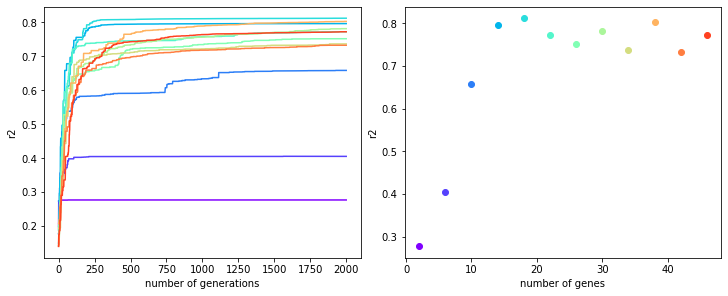

In [10]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])

    # opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
plt.ylabel("r2")
plt.xlabel("number of generations")
# plt.ylim([0.1, 0.47])
# plt.yscale("log")
plt.subplot(1,2,2)
# ax2 = fig.add_subplot(gs1[0, 1])

# plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')
[plt.scatter(N_genes_enemble[i], opt_max_ensemble[i,-1], color=cmap(i/N_ensemble)) for i in range(N_ensemble)]
plt.xlabel("number of genes")
plt.ylabel("r2")
# plt.ylim([0.1, 0.47])
# plt.savefig("r2_Ngenesb.png", dpi=200)

[0.85232117 0.79720032]


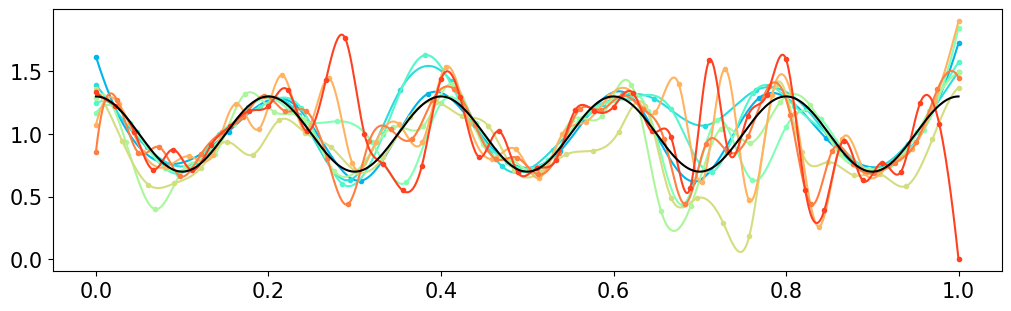

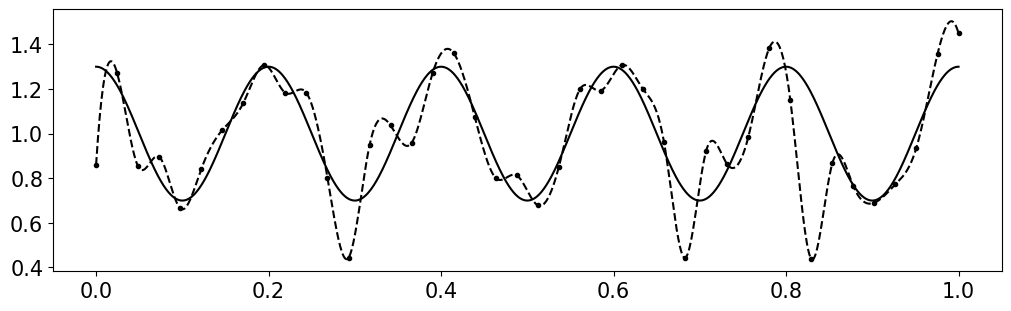

In [21]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble):
    if i<=2:
        continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best], '.', color=cmap(i/N_ensemble))




fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black")
i = -2
res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best], '.', color="black")
# ax.set_ylim(invSR_lims)

# fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

# time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
# ax.plot(depth, y )
# ax.plot(depth, y_pred, color="black")

# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

28
[0.74368063 0.66269292]


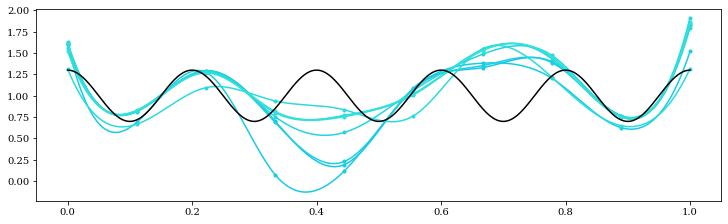

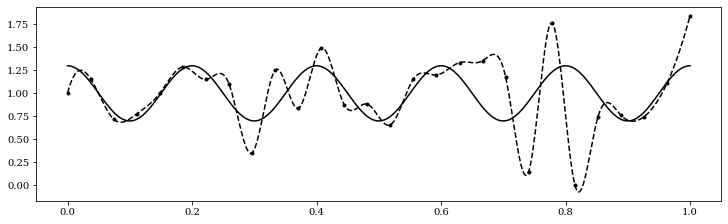

In [620]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

# for i, res in enumerate(res_ensemble):
for i in np.arange(32,40):
    res = res_ensemble[i]
    # if i<=40:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best], '.', color=cmap(i/N_ensemble))




fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black")
i = 110
res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
print(len(depth_genes))
arg_best = np.argmin(res.F.mean(axis=1))
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best], '.', color="black")
# ax.set_ylim(invSR_lims)

# fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

# time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
# ax.plot(depth, y )
# ax.plot(depth, y_pred, color="black")

# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

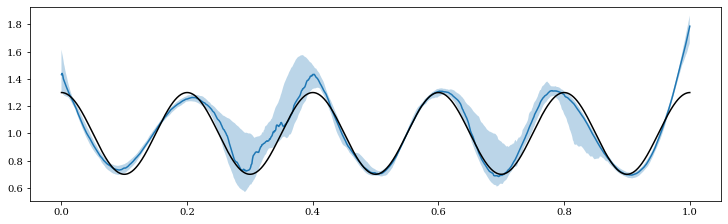

In [593]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
N_indi = 9 
invSR_pop = np.zeros([len(depth), N_ensemble, N_indi])
# res_ensemble_x = res_ensemble[10:]
for i, res in enumerate(res_ensemble):
    # if i<10:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    for j in range(N_indi):
        arg_best = np.argmin(res.F.sum(axis=1))
        invSR_pop[:, i, j] = interpolator([depth_genes, res.X[j]], depth)
        # ax.plot(depth, interpolator([depth_genes, res.X[j]], depth), color="black",alpha=0.1)
        # ax.plot(depth_genes, res.X[j], '.', alpha=0.1, color="black")
invSR_pop = invSR_pop[:,40:]
invSR_pop = invSR_pop.reshape(len(depth), -1)
ax.plot(depth, np.median(invSR_pop,axis=-1))
ax.fill_between(depth, *np.quantile(invSR_pop, [0.25, 0.75], axis=-1), alpha=0.3)
# ax.fill_between(depth, *np.quantile(invSR_pop, [0.1, 0.9], axis=-1), alpha=0.3)

ax.plot(depth, func_inv_SR(depth),color="black",zorder=100)


# MCMC

## In search for SR
(frequencies are presumed to be known constant)

In [498]:
log_likelihood_rednoise([depth_genes, true_genes], [depth, y], fs, [sigma_true, rho_true]), log_likelihood_rednoise([depth_genes, true_genes], [depth, y], fs, [0.5, 0.1])

(250.6880641137214, -52.51932192828781)

In [218]:
# %lprun -f log_likelihood_AR1 log_likelihood_AR1([depth_genes, true_genes], [depth, y], fs, [0.5, 0.1])

In [22]:
i = -2
res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
N_genes = len(depth_genes)

In [607]:
i=7
depth_genes_ensemble[8*i:8*i+8]

[array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4     

In [505]:
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]
invSR_random = np.random.randn(N_genes)*(invSR_lims[1]-invSR_lims[0]) + invSR_lims[0]

nwalkers = 40
params_noise_ini = [0.7, 0.7]
# params_noise_ini = [0.7]
# params_noise_ini = []

params_ini = np.hstack([params_noise_ini, invSR_best])
pos = params_ini + 1e-4 * np.random.randn(nwalkers, N_genes+len(params_noise_ini))
# pos = invSR_random + 1e-4 * np.random.randn(nwalkers, N_genes)
params_best = np.hstack([sigma_true, rho_true, true_genes])

nwalkers, ndim = pos.shape
# log_posterior = log_posterior_whitenoise
log_posterior = log_posterior_rednoise_v1
log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y], fs=fs, interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims) 

# log_posterior = log_posterior_whitenoise_v0
# log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y], fs=fs, interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims, sigma=0.7) 


with Pool(processes=1) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_testcase, pool=pool)
    sampler.run_mcmc(pos, 5000, progress=True)
    # print("Multiprocessing took {0:.1f} seconds".format(multi_time))

100%|██████████| 5000/5000 [07:20<00:00, 11.35it/s]


In [30]:
print("acceptance_fraction", sampler.acceptance_fraction.mean())
tau = sampler.get_autocorr_time()
print("autocorr_time",tau)

acceptance_fraction 0.20203600000000002


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 44 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [493.00451672 520.78961012 602.86672559 529.54587188 529.24437024
 458.60643038 362.71679523 348.09344653 352.66027833 331.77809847
 301.41085545 321.88414373 327.31288559 367.40456647 369.64851873
 360.60398877 376.5125271  388.13411506 354.8692604  334.45175641
 433.8044663  443.70152789 395.29769895 357.62366964 377.77281805
 404.33254246 395.70054457 370.92991715 360.55066204 364.93384272
 357.51837861 347.1023335  508.13116918 526.80947817 470.56691459
 546.39008252 446.87274999 348.37278702 390.76420633 386.93360078
 354.99394326 380.6228337  352.43264817 417.77976189]

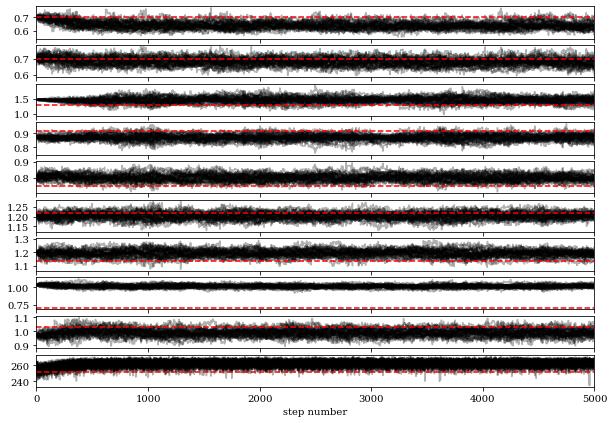

In [517]:
ndim = 10
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
logprob_sample = sampler.get_log_prob()

# labels = ["m", "b", "log(f)"]
for i in range(ndim-1):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(params_best[i], ls="--", color="red")
    # ax.set_ylabel(labels[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].plot(logprob_sample, "k", alpha=0.3)
axes[-1].axhline(log_probability_testcase(params_best), ls="--", color="red")
axes[-1].set_xlabel("step number");     

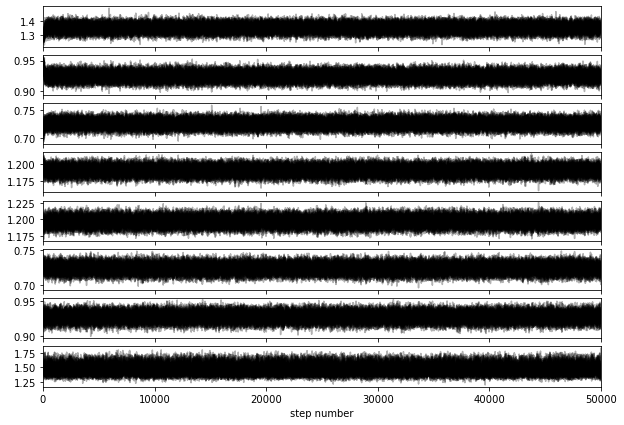

In [261]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
# labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    # ax.set_ylabel(labels[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");     

In [511]:
flat_samples = sampler.get_chain(discard=1000, thin=50, flat=True)
print(flat_samples.shape)

(3200, 20)


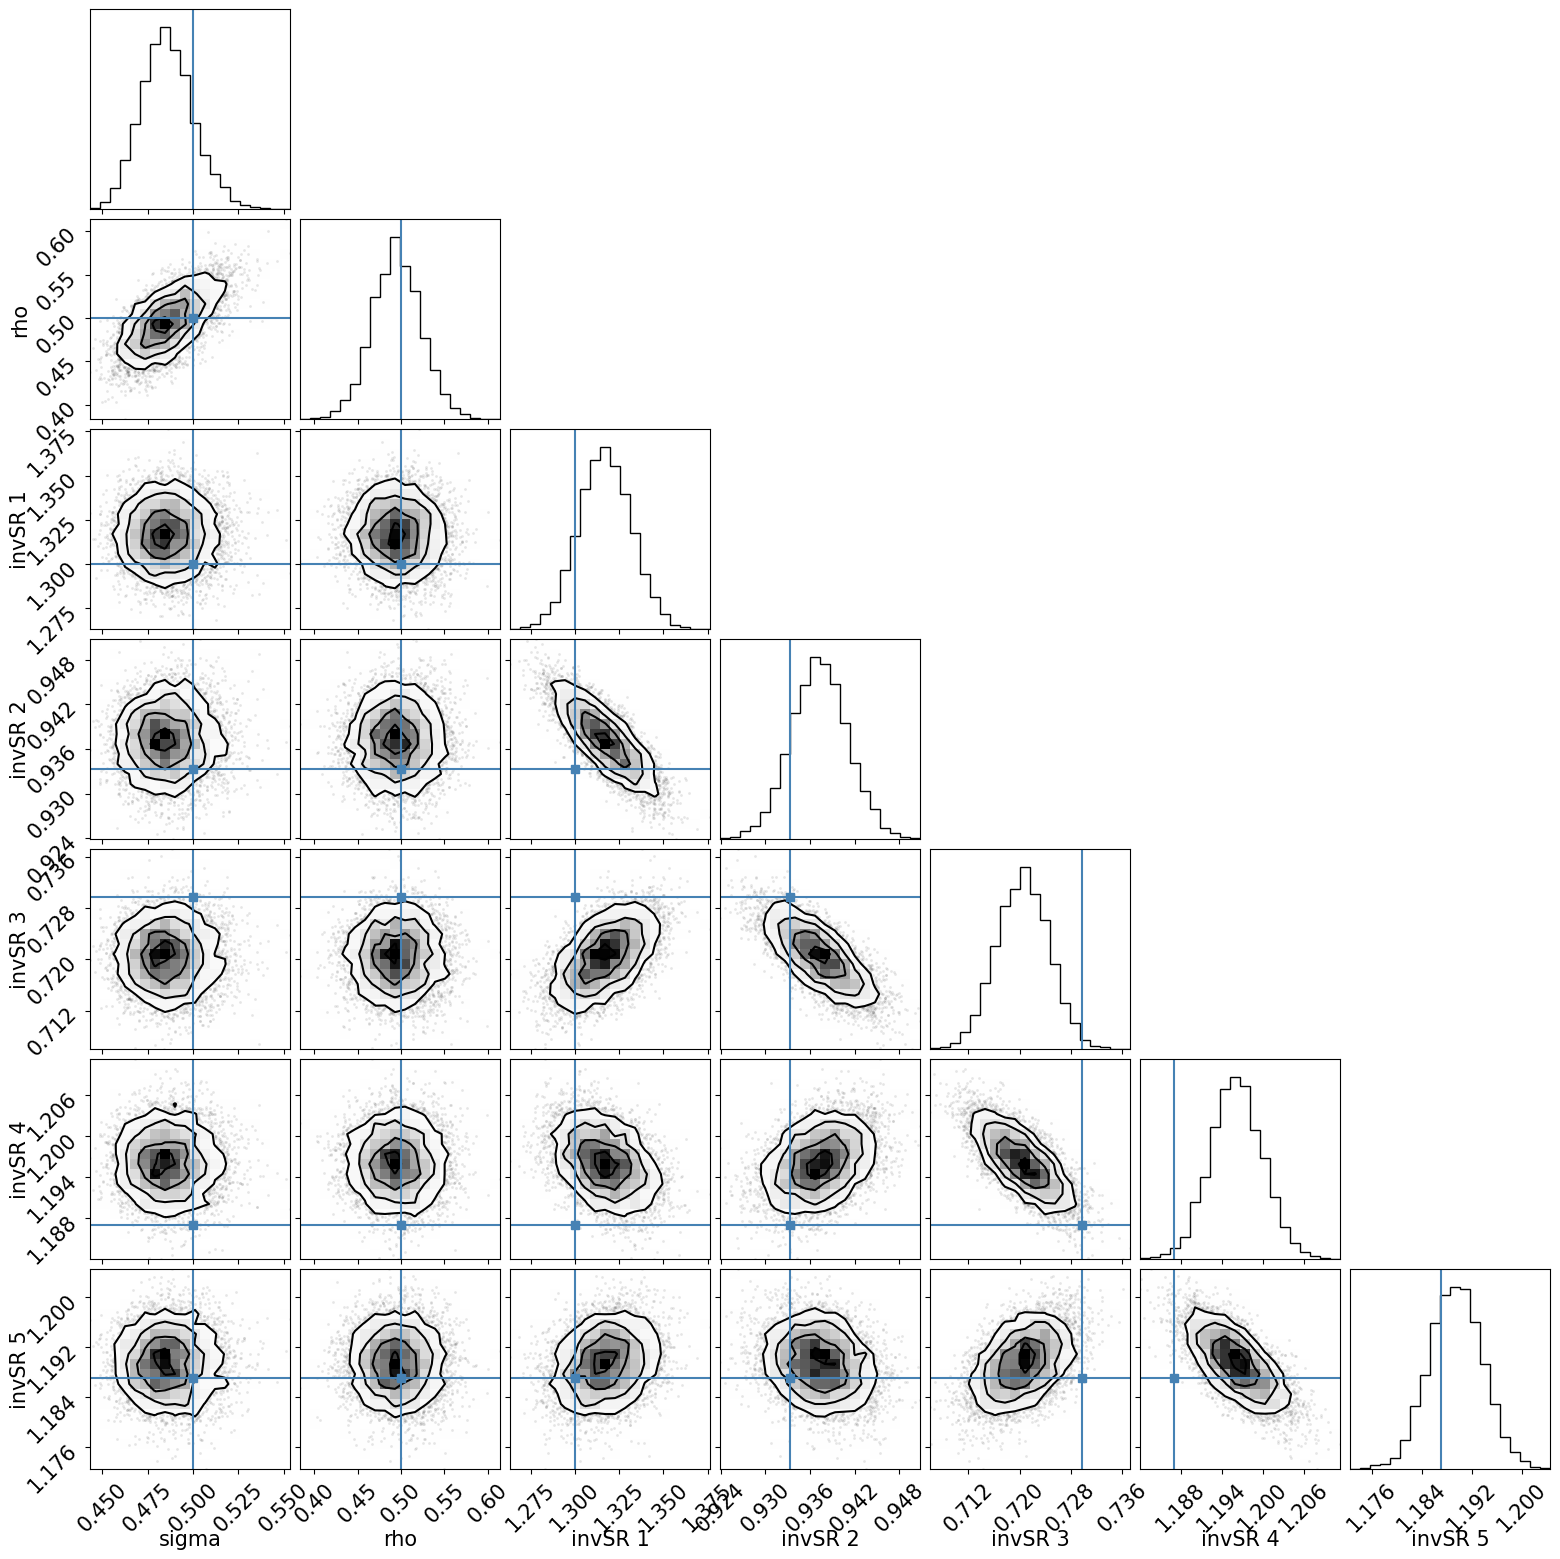

In [213]:
# labels = list(map(r"invSR{0}".format, range(1, N_genes + 1)))
# n_genes_plot = N_genes
n_genes_plot = 5
true_values = np.hstack([[sigma_true, rho_true], true_genes[:n_genes_plot]])
labels = ["sigma", "rho"] + [f"invSR {i}" for i in range(1,n_genes_plot+1)]
fig = corner.corner(
    flat_samples[:,:n_genes_plot+2], truths=true_values, labels=labels
)

# corner.overplot_lines(fig, invSR_best[:n_genes_plot], color="C1",label="GA")
# corner.overplot_points(fig, invSR_best[None,:n_genes_plot], marker="s", color="C1")
# plt.legend()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


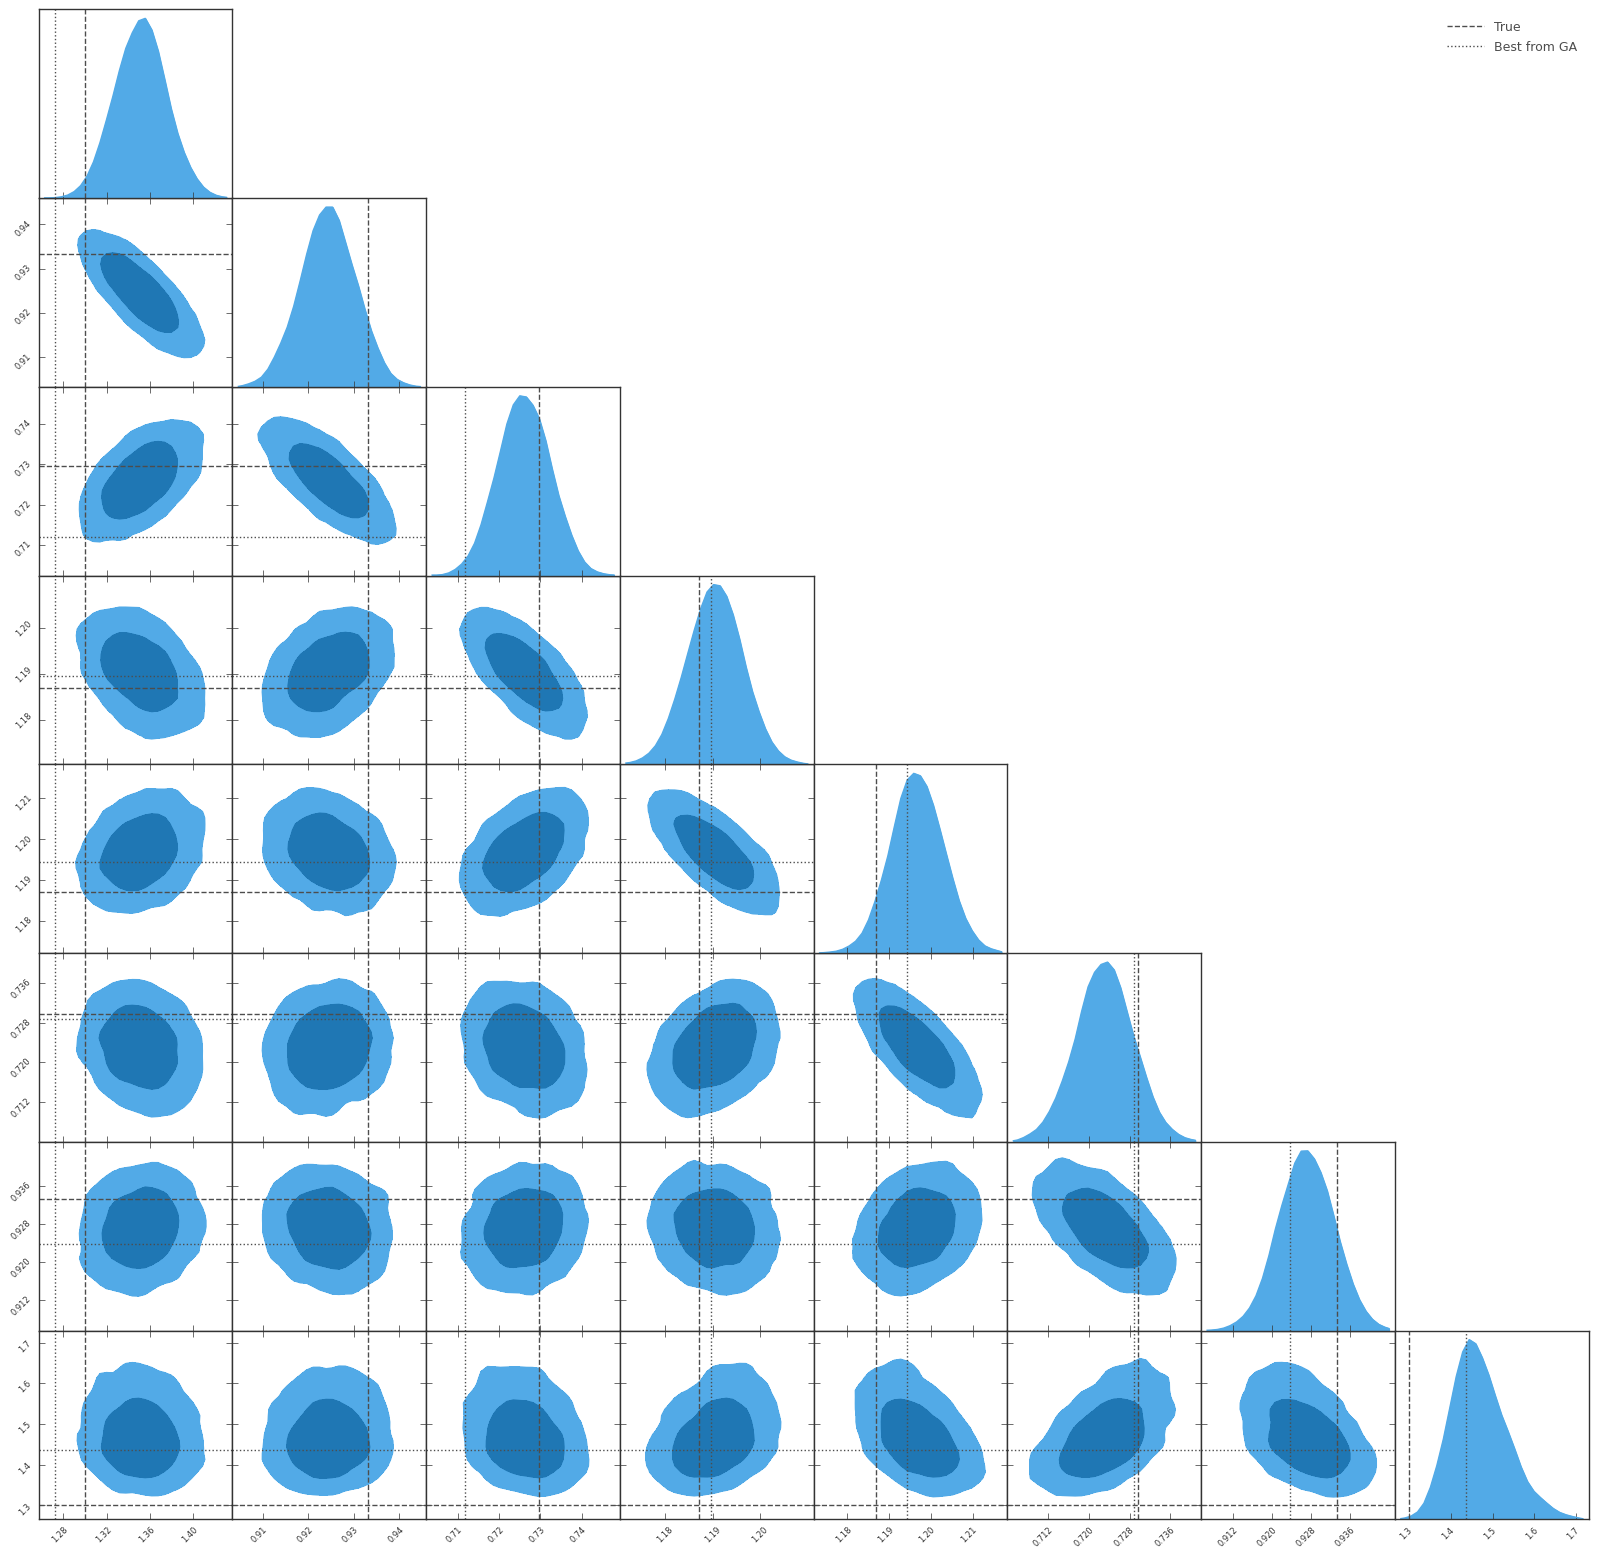

In [91]:
# fig = corner.corner(
#     flat_samples, truths=func_inv_SR(depth_genes)
# )
truthLabels = ["True", "Best from GA"]
GTC = pygtc.plotGTC(chains=[flat_samples],
                    # paramNames=names,
                    # chainLabels=chainLabels,
                    truths= [func_inv_SR(depth_genes), invSR_best],
                    truthLabels=truthLabels,
                    figureSize = 20,
                    # figureSize='AandA_page'
                    )
# corner.overplot_lines(fig, invSR_best, color="C1")
# corner.overplot_points(fig, invSR_best[None], marker="s", color="C1")

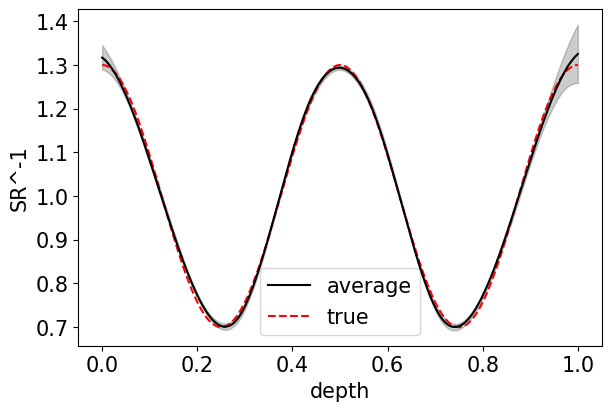

In [215]:
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,2:]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)

plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()

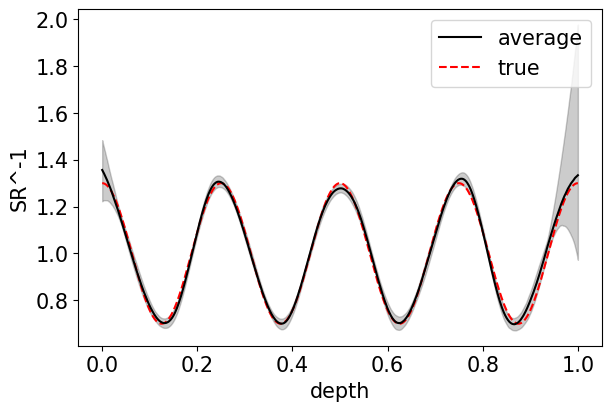

In [145]:
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)

plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()

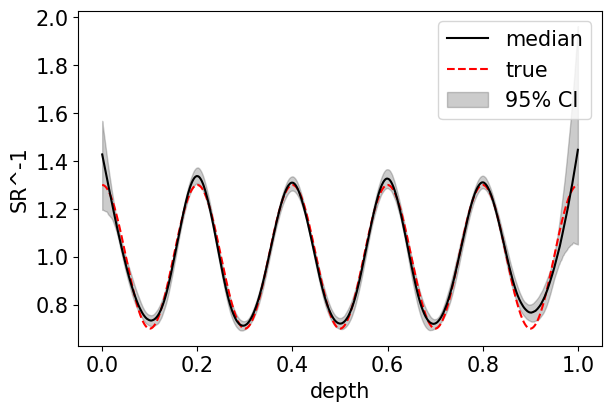

In [187]:
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="median")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black", label="95% CI")

# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)

plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_sinek10.png")

(8000, 44)


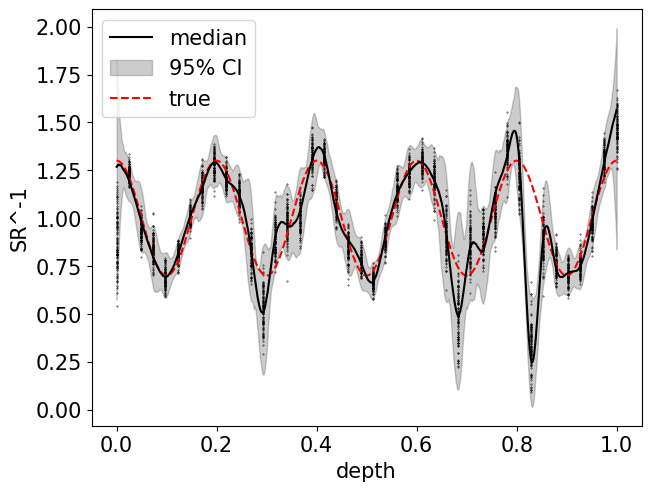

In [45]:
flat_samples = sampler.get_chain(discard=1000, thin=50, flat=True)
print(flat_samples.shape)
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,len(params_noise_ini):]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.005, 0.995],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="median")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black", label="95% CI")

# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)
for i in range(100):
    plt.scatter(depth_genes, flat_samples[i,len(params_noise_ini):], s=0.1, color="black")
plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_sinek10.png")

(3200, 20)


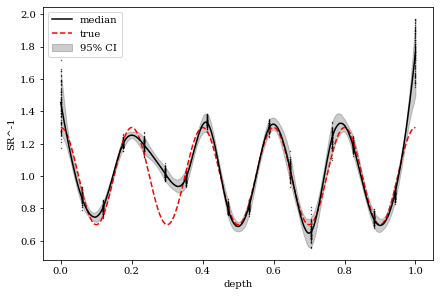

In [515]:
flat_samples = sampler.get_chain(discard=1000, thin=50, flat=True)
print(flat_samples.shape)
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,len(params_noise_ini):]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)
# invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.005, 0.995],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="median")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black", label="95% CI")

# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)
for i in range(100):
    plt.scatter(depth_genes, flat_samples[i,len(params_noise_ini):], s=0.1, color="black")
plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_sinek10.png")

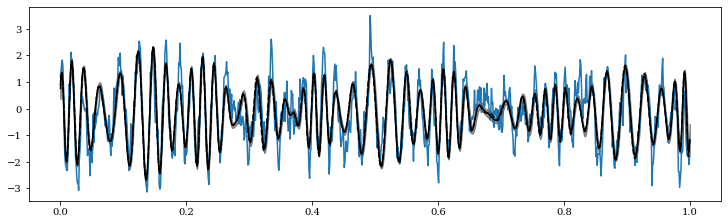

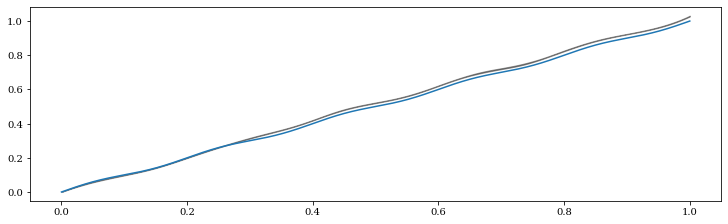

In [513]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, y)

invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)

y_pred_sample =  np.array([ invSR_to_predx([depth_genes, flat_samples[i,len(params_noise_ini):]])[1] for i in range(1000)])
alphas = [0.01, 0.99]
alphas = [0.05, 0.95]

ypred_lo, ypred_up = np.quantile(y_pred_sample, alphas,axis=0)

time_best, y_pred = invSR_to_predx([depth_genes, invSR_best])
# axs[0].plot(depth, time, color="black")
# 
ax.plot(depth, y_pred, "--", color="black")
ax.fill_between(depth, ypred_lo, ypred_up, color="black", alpha=0.4)
ax.plot(depth, np.median(y_pred_sample, axis=0), color="black")

# ax.set_xlim([90,100])
# time_nominal, y_pred = invSR_to_predx([depth_genes, func_invSR_nominal(depth_genes)])


fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
time_sample =  np.array([ invSR_to_predx([depth_genes, flat_samples[i,len(params_noise_ini):]])[0] for i in range(1000)])
alphas = [0.05, 0.95]
lo, up = np.quantile(time_sample, alphas,axis=0)
ax.fill_between(depth, lo, up, color="black", alpha=0.4)
ax.plot(depth, time)


## In search for frequencies

In [272]:
def log_posterior_whitenoise(params, depth_invSR, data, prior_params_freq, interpolator=interpolate_CubicSpline, invSR_lims=[0,2],
                             sigma_lims=[1e-4, 2]):
    """ same as log_posterior_whitenoise_v1 but frequencies are no longer constant but treated as parameters
    params: array[1 + N_genes] = [sigma, rho (from AR1), array of invSR]
    prior_freq: array[N_freq, 2] :  parameters of prior for frequencies fs, (Gaussian with muy and sigma as params) 
    """
    sigma =  params[0]
    N_freq = len(prior_params_freq)
    freqs = params[1:1+N_freq]
    fs = freqs[0] + freqs[1:]
    invSR = params[1+N_freq:]
    # print(freqs, sigma, invSR)
    
    lp_invSR = log_uniform(invSR, invSR_lims)
    lp_sigma = log_loguniform(sigma, sigma_lims)    
    lp_fs = sum([log_gaussian(freqs[i], prior_params_freq[i]) for i in range(N_freq) ])
    lp = lp_invSR + lp_sigma + lp_fs
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_whitenoise([depth_invSR, invSR], data, fs, sigma, interpolator=interpolator)

In [43]:
%lprun -f log_likelihood_whitenoise  log_likelihood_whitenoise([depth_genes, invSR_best], data=[depth, y],interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims,  fs=fs, sigma=0.8)         


Timer unit: 1e-09 s

Total time: 0.00770338 s
File: /users/nhoanghoai/AstroGeo/routines_model.py
Function: log_likelihood_whitenoise at line 244

Line #      Hits         Time  Per Hit   % Time  Line Contents
   244                                           def log_likelihood_whitenoise(invSR, data, fs, sigma, interpolator=interpolate_CubicSpline, *args, **kwargs):
   245                                               """_summary_: 
   246                                               
   247                                                   loglikelihood for the linear model with predictors variable are fourier harmonics of frequencies fs
   248                                                   of fitting the data, when used the age model derived from the invSR.
   249                                                   age model: given points of inverse SR, interpolate with an interpolator and integrate along depth
   250                                                   to obtain time.

In [301]:
%lprun -f log_posterior_whitenoise  log_posterior_whitenoise(params_best, depth_invSR=depth_genes, data=[depth, y],interpolator=interpolate_CubicSpline, \
                                   invSR_lims=invSR_lims, sigma_lims=[1e-4, 2], prior_freq=prior_freq)

Timer unit: 1e-09 s

Total time: 0.0116542 s
File: /tmp/ipykernel_341108/405042703.py
Function: log_posterior_whitenoise at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def log_posterior_whitenoise(params, depth_invSR, data, prior_freq, interpolator=interpolate_CubicSpline, invSR_lims=[0,2],
     2                                                                        sigma_lims=[1e-4, 2]):
     3                                               """ same as log_posterior_whitenoise_v1 but frequencies are no longer constant but treated as parameters
     4                                               params: array[1 + N_genes] = [sigma, rho (from AR1), array of invSR]
     5                                               prior_freq: array[N_freq, 2] :  parameters of prior for frequencies fs, (Gaussian with muy and sigma as params) 
     6                                               """
     7         1       7444.

In [323]:
prior_params_freq = np.array([[50.5, 10], [5.525, 0.125], [7.455, 0.015], [17.3, 0.15], [17.85, 0.15], [4.257564, 0.00002]])
prior_params_freq = prior_params_freq/180/3600*np.pi*1e6

In [344]:
log_posterior = log_posterior_whitenoise

arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]
invSR_random = np.random.randn(N_genes)*(invSR_lims[1]-invSR_lims[0]) + invSR_lims[0]

nwalkers = 32
params_noise_ini = [0.5]
params_freq_ini = prior_params_freq[:,0]
params_ini = np.hstack([params_noise_ini, params_freq_ini, invSR_best])
params_best = np.hstack([sigma_true, p0, muy_k, true_genes])
pos_ini = params_ini + 1e-4 * np.random.randn(nwalkers, len(params_ini))
# pos = invSR_random + 1e-4 * np.random.randn(nwalkers, N_genes)

nwalkers, ndim = pos_ini.shape
log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y],interpolator=interpolate_CubicSpline,
                                   invSR_lims=invSR_lims, sigma_lims=[1e-4, 2], prior_freq=prior_params_freq) 

print(f"log posterior initial point: {log_probability_testcase(pos_ini[0])}")
print(f"log posterior best point: {log_probability_testcase(params_best)}")


with Pool(processes=1) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_testcase, pool=pool)
    sampler.run_mcmc(pos_ini, 5000, progress=True)


log posterior initial point: 26.079059366917164
log posterior best point: 88.66482377222958


100%|██████████| 5000/5000 [06:15<00:00, 13.31it/s]


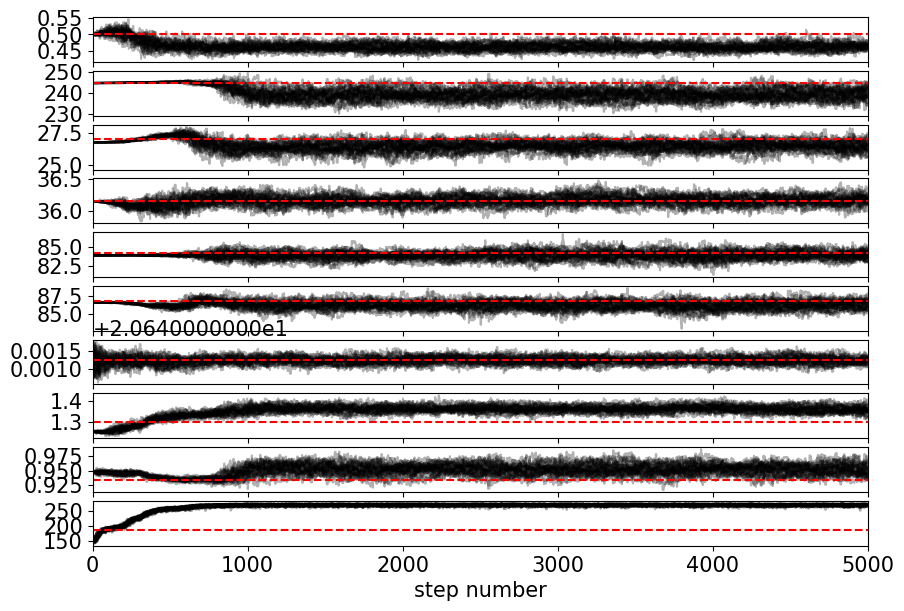

In [309]:
ndim = 10
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
logprob_sample = sampler.get_log_prob()

# labels = ["m", "b", "log(f)"]
for i in range(ndim-1):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(params_best[i], ls="--", color="red")
    # ax.set_ylabel(labels[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].plot(logprob_sample, "k", alpha=0.3)
axes[-1].axhline(log_probability_testcase(params_best), ls="--", color="red")
axes[-1].set_xlabel("step number");     

In [310]:
print("acceptance_fraction", sampler.acceptance_fraction.mean())
tau = sampler.get_autocorr_time()
print("autocorr_time",tau)

acceptance_fraction 0.34630625


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 15 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [226.60862057 384.73220764 229.49598819 147.92720911 175.89973779
 149.60244243 139.66973698 425.91316656 276.15981944 399.93719823
 351.72993722 371.42451505 384.73419768 245.01554967 413.94645666]

In [312]:
# tau = sampler.get_autocorr_time()
# burnin = int(2 * np.max(tau))
# thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=1000, thin=50, flat=True)
print(flat_samples.shape)

(2560, 15)


In [335]:
freqs_true

array([244.67440141,  27.04958786,  36.15093207,  84.1956285 ,
        86.83107083,  20.64125275])

(45.0, 55.0)

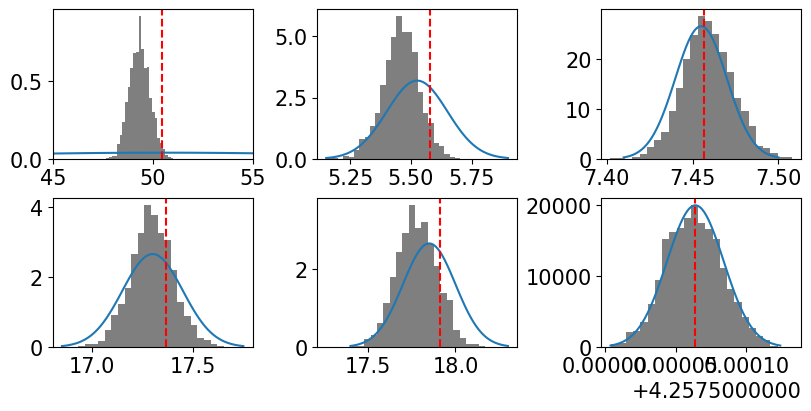

In [345]:
fig, axs = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
coef = 1/180/3600*np.pi*1e6
for i, ax in enumerate(axs.flatten()):

    # variance = 1
    # sigma = math.sqrt(variance)
    muy, sigma = prior_params_freq[i]/coef
    x = np.linspace(muy - 3*sigma, muy + 3*sigma, 100)
    ax.plot(x, sp.stats.norm.pdf(x, muy, sigma))
    ax.hist(flat_samples[:,1+i]/coef, density=True, color="k", alpha=0.5, bins=25)
    ax.axvline(freqs_true[i]/coef, ls="--", color="red")
axs[0,0].set_xlim(45,55)

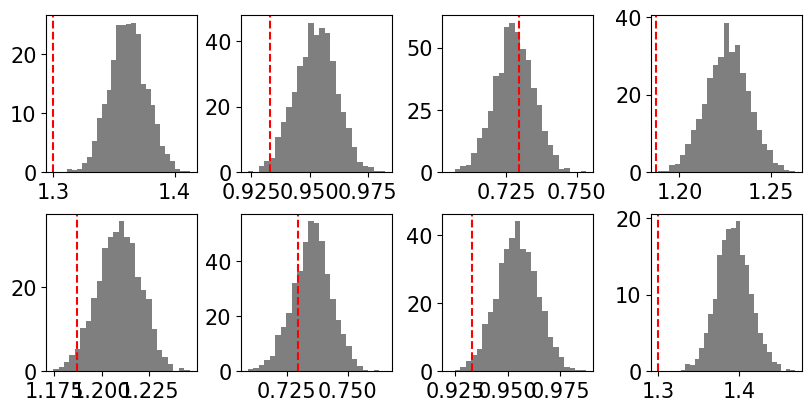

In [352]:
fig, axs = plt.subplots(2,N_genes//2, figsize=(8,4),constrained_layout=True)
for i, ax in enumerate(axs.flatten()):
    # variance = 1
    # sigma = math.sqrt(variance)
    # muy, sigma = prior_params_freq[i]/coef
    # x = np.linspace(muy - 3*sigma, muy + 3*sigma, 100)
    # ax.plot(x, sp.stats.norm.pdf(x, muy, sigma))
    ax.hist(flat_samples[:,1+len(freqs_true)+i], density=True, color="k", alpha=0.5, bins=25)
    ax.axvline(true_genes[i], ls="--", color="red")
# axs[0,0].set_xlim(45,55)

In [358]:
flat_samples.shape

(2560, 15)

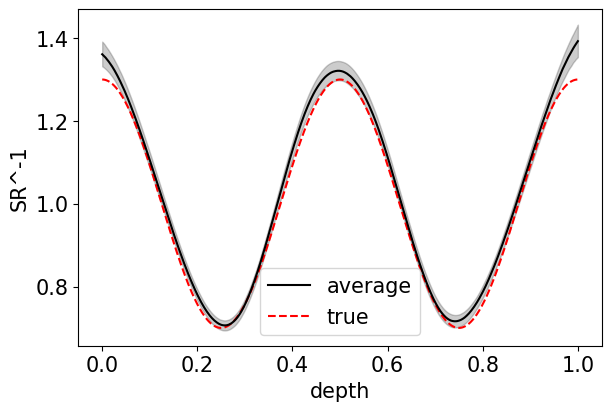

In [357]:
inds = np.random.randint(len(flat_samples), size=1000)
# genes_value = flat_samples[:,1+len(freqs_true)+i]
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,1+len(freqs_true):]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)

plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()